Загружаем данные.

Последние семь дней (это просто продублированные значения из таблицы за последнюю известную дату - 8 дней назад).

Вам нужно спрогнозировать цену биткоина (Price) на последние семь дней.

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt

data = pd.read_csv("Bitcoin_kaggle.csv",
                  delimiter=';',
                  parse_dates=True,
                  index_col='Date'
                  )

print(len(data))

data = data.sort_index()

data.tail(10)

Преобразуем Price в нужный формат.

In [ ]:
data['Price'] = data['Price'].apply(lambda x: float(x.replace(",","")))

<Axes: xlabel='Date'>

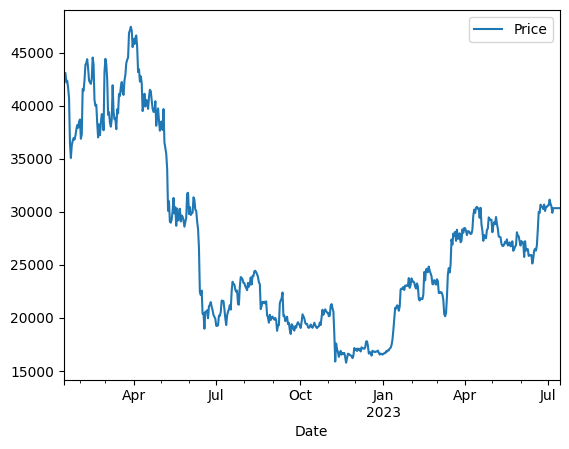

In [ ]:
data = data[['Price']]

data.plot()

In [ ]:
def code_mean(data, cat_feature, real_feature):
    return dict(data.groupby(cat_feature)[real_feature].mean())

Извлечем признаки

In [ ]:
target = "Price"

def preprocess_data(data, lag_start=7, lag_end=20, test_size=0.02):

    data = pd.DataFrame(data.copy())

    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data) * (1 - test_size))
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data[f"lag_{i}"] = data[target].shift(i)

    data["day"] = data.index.day

    # считаем средние только по тренировочной части, чтобы избежать лика
    data["day_average"] = list(map(code_mean(data[:test_index], "day", target).get, data.day))

    # выкидываем закодированные средними признаки
    data.drop(["day"], axis=1, inplace=True)

    data = data.dropna()
    data = data.reset_index(drop=True)

    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop([target], axis=1)
    y_train = data.loc[:test_index][target]
    X_test = data.loc[test_index:].drop([target], axis=1)
    y_test = data.loc[test_index:][target]

    return X_train, X_test, y_train, y_test

Обучим линейную регрессию (подберем размер теста так, чтобы в него попали ровно те 7 дней, для которых мы делаем прогноз)

7


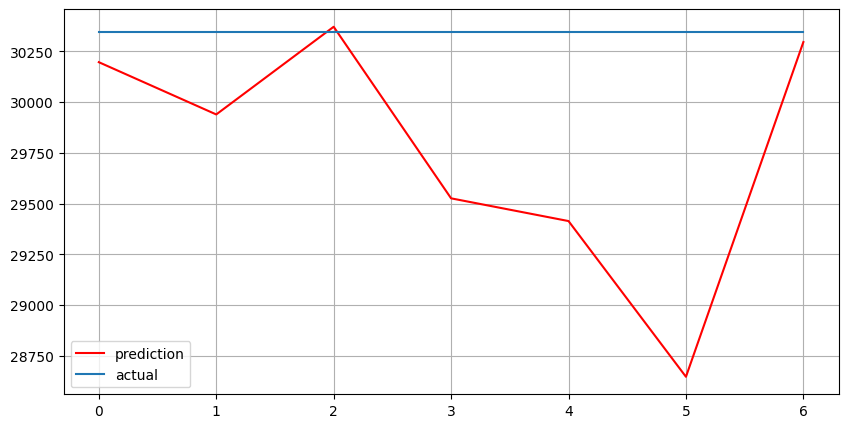

In [ ]:
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = preprocess_data(data, test_size=0.035, lag_start=7, lag_end=14)

print(len(y_test))

lr = LinearRegression()
lr.fit(X_train, y_train)
preds = lr.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(preds, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")

In [ ]:
X_test['Date'] = data.index[-7:]
X_test['Price'] = preds

X_test.set_index('Date', inplace=True)

In [ ]:
X_test[['Price']]

,Price
Date,
2023-07-08,30196.939547
2023-07-09,29939.525845
2023-07-10,30371.300482
2023-07-11,29526.355905
2023-07-12,29414.429412
2023-07-13,28647.518808
2023-07-14,30296.037932


In [ ]:
X_test[['Price']].to_csv("prediction_linreg.csv")